# Toy Models of Superposition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/tms.ipynb)

Let's run through an example using Anthropic's toy models of superposition. 

This example is mostly to test that our SGLD estimator is working as expected and to figure out how to integrate this in an SGD setting.

Credits: [Chen et al. (2023)](https://arxiv.org/abs/2310.06301).

In [ ]:
%pip install devinterp matplotlib scipy

In [1]:
import os
from typing import Iterable, Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import yaml
import itertools
from torch.utils.data import TensorDataset
from torch.nn import functional as F

from devinterp.zoo.tms import ToyAutoencoder, SyntheticBinaryValued
from devinterp.slt.cov import BetweenLayerCovarianceAccumulator, CovarianceAccumulator
from devinterp.slt.llc import estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD


DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

In [2]:
def generate_2d_kgon_vertices(k, rot=0., pad_to=None, force_length=0.9):
    """Set the weights of a 2D k-gon to be the vertices of a regular k-gon."""
    # Angles for the vertices
    theta = np.linspace(0, 2*np.pi, k, endpoint=False) + rot

    # Generate the vertices
    x = np.cos(theta)
    y = np.sin(theta)
    result = np.vstack((x, y))

    if pad_to is not None and k < pad_to:
        num_pad = pad_to - k
        result = np.hstack([result, np.zeros((2, num_pad))])
        
    return (result * force_length)

def generate_init_param(m, n, init_kgon, prior_std=1., no_bias=True, init_zerobias=True, seed=0, force_negb=False, noise=0.01):
    np.random.seed(seed)
    
    if init_kgon is None or m != 2:
        init_W = np.random.normal(size=(m, n)) * prior_std
    else:
        assert init_kgon <= n
        rand_angle = np.random.uniform(0, 2 * np.pi, size=(1,))
        noise = np.random.normal(size=(m, n)) * noise
        init_W = generate_2d_kgon_vertices(init_kgon, rot=rand_angle, pad_to=n) + noise
    
    if no_bias:
        param = {"W": init_W}
    else:
        init_b = np.random.normal(size=(n, 1)) * prior_std
        if force_negb:
            init_b = -np.abs(init_b)
        if init_zerobias:
            init_b = init_b * 0
        param = {
            "W": init_W, 
            "b": init_b
        }
    return param

In [3]:
def create_and_train(
    m: int,
    n: int,
    num_samples: int,
    batch_size: Optional[int] = 1,
    num_epochs: int = 100,
    lr: float = 0.001,
    log_ivl: Iterable[int] = [],
    device=DEVICE,
    momentum=0.9,
    weight_decay=0.0,
    init_kgon=None,
    no_bias=False,
    init_zerobias=False,
    prior_std=10.,
    seed=0
):
    model = ToyAutoencoder(m, n, final_bias=True)

    init_weights = generate_init_param(n, m, init_kgon, no_bias=no_bias, init_zerobias=init_zerobias, prior_std=prior_std, seed=seed)
    model.embedding.weight.data = torch.from_numpy(init_weights["W"]).float()
    
    if "b" in init_weights:
        model.unembedding.bias.data = torch.from_numpy(init_weights["b"].flatten()).float()

    dataset = SyntheticBinaryValued(num_samples, m, 1)
    batch_size = batch_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    logs = pd.DataFrame([{"loss": None, "acc": None, "step": step} for step in log_ivl])

    model.to(device)
    weights = []

    def log(step):
        loss = 0.0
        acc = 0.0
        length = 0

        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                outputs = model(batch)
                loss += criterion(outputs, batch).item()
                acc += (outputs.round() == batch).float().sum().item()
                length += len(batch)

        loss /= length
        acc /= length

        logs.loc[logs["step"] == step, ["loss", "acc"]] = [loss, acc]
        weights.append({k: v.cpu().detach().clone().numpy() for k, v in model.state_dict().items()})

    step = 0
    log(step)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        for batch in dataloader:
            batch = batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            step += 1

            if step in log_ivl:
                log(step)

    return logs, weights

In [88]:
def plot_polygon(
    W: torch.Tensor,
    b=None,
    ax=None,
    ax_bias=None,
    ax_wnorm=None,
    hull_alpha=0.3,
    dW=None,
    dW_scale=0.3,
    orderb=True,
):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2:
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

    if W.shape[0] == 2:  # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0,
                0,
                W_sorted[0, i],
                W_sorted[1, i],
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.003,
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col],
                    W[1, col],
                    dW[0, col],
                    dW[1, col],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="r",
                    width=0.005,
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")

    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")

        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], "b-")

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")

    if b is not None and ax_bias is not None:
        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ["r" if val < 0 else "b" for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(
            yticks - 0.4,
            np.abs(b_plot),
            height=0.4,
            color=bar_colors,
            align="edge",
        )
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis="y", labelsize="x-small")
        ax_bias.tick_params(axis="x", labelsize="x-small")

    if ax_wnorm is not None:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax


def plot_polygons(Ws, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W in zip(axes, Ws):
        plot_polygon(W, ax=ax)


def plot_losses_and_polygons(steps, losses, highlights, Ws):
    fig = plt.figure(figsize=(15, 6))

    gs = fig.add_gridspec(2, len(Ws))
    ax_losses = fig.add_subplot(gs[1, :])
    ax_polygons = []

    max_x, min_x = max([np.max(W[0]) for W in Ws]), min([np.min(W[0]) for W in Ws])
    max_y, min_y = max([np.max(W[1]) for W in Ws]), min([np.min(W[1]) for W in Ws])

    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[0, i], adjustable='box') 
        ax.set_aspect('equal')
        ax_polygons.append(ax)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    ax_losses.plot(steps, losses)
    ax_losses.set_xlabel("Step")
    ax_losses.set_ylabel("Loss")
    ax_losses.set_xscale("log")
    ax_losses.set_yscale("log")

    for i, step in enumerate(highlights):
        ax_losses.axvline(step, color="gray", linestyle="--")

    plot_polygons(Ws, ax_polygons)

    plt.suptitle("Loss and Weight snapshots")
    plt.tight_layout()


(2, 8)


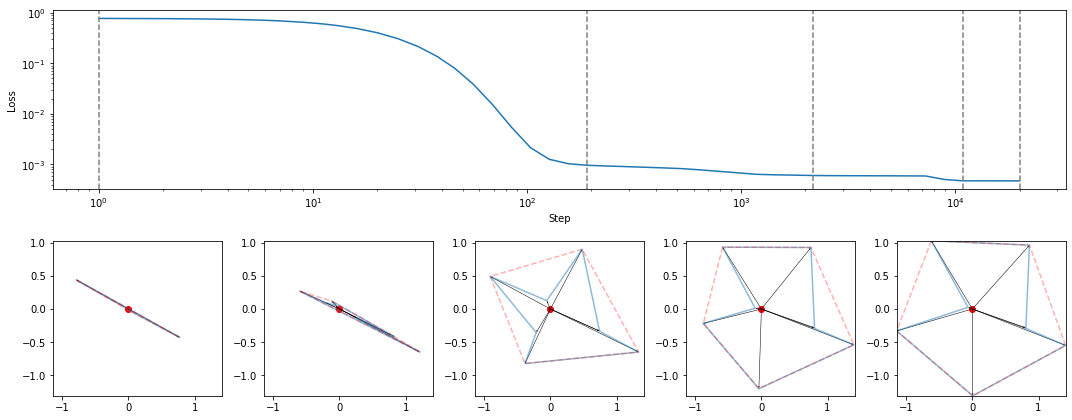

In [89]:
NUM_FEATURES = 8
NUM_HIDDEN_UNITS = 2
NUM_SAMPLES = 1000  
NUM_EPOCHS = 20000
INIT_KGON = 2
NUM_OBSERVATIONS = 50

torch.manual_seed(1)
steps = sorted(list(set(np.logspace(0, np.log10(NUM_EPOCHS), NUM_OBSERVATIONS).astype(int))))

PLOT_STEPS = [min(steps, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, NUM_EPOCHS - 1]]
PLOT_INDICES = [steps.index(s) for s in PLOT_STEPS]
logs, weights = create_and_train(NUM_FEATURES, NUM_HIDDEN_UNITS, num_samples=NUM_SAMPLES, log_ivl=steps, batch_size=100, lr=0.01, num_epochs=NUM_EPOCHS, init_kgon=INIT_KGON, init_zerobias=False, seed=1)

weights_to_plot = [weights[i]['embedding.weight'] for i in PLOT_INDICES]
losses = [logs.loc[logs['step'] == s, 'loss'].values[0] for s in steps]
plot_losses_and_polygons(steps, losses, PLOT_STEPS, weights_to_plot)
plt.show()

In [91]:
# Sweep SGLD hyperparameters

NUM_SAMPLES_TEST = 200
NUM_DRAWS_SGLD = 100
NUM_CHAINS_SGLD = 5

dataset = SyntheticBinaryValued(NUM_SAMPLES_TEST, NUM_FEATURES, 1)
dataset_double = TensorDataset(dataset.data, dataset.data)
model = ToyAutoencoder(NUM_FEATURES, NUM_HIDDEN_UNITS, final_bias=True)

def sweep_lambdahat_estimation_hyperparams(
        model, 
        dataset, 
        device=DEVICE,
        sgld_kwargs=None,
        num_draws=NUM_DRAWS_SGLD,
        num_chains=NUM_CHAINS_SGLD
):
    observations = []
    hyperparam_combos = list(itertools.product([1, 10, 30, 100, 300], [1e-5, 1e-4, 1e-3, 1e-2]))

    sgld_kwargs = sgld_kwargs or {}
    sgld_kwargs.setdefault("num_samples", len(dataset))
    sgld_kwargs.setdefault("elasticity", 1.)

    for batch_size, lr in tqdm(hyperparam_combos, desc="Sweeping hyperparameters",):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        model.load_state_dict({k: torch.Tensor(v) for k, v in weights[-1].items()})

        observation = estimate_learning_coeff_with_summary(
                model,
                loader,
                F.mse_loss,
                device=device,
                sampling_method=SGLD,
                optimizer_kwargs={
                    "lr": lr,
                    **sgld_kwargs
                },
                verbose=False,
                num_draws=num_draws,
                num_chains=num_chains,
                online=True
            )

        for t_sgld in range(num_draws):
            observations.append({
                    "llc": observation["llc/means"][t_sgld].item(),
                    "llc/std": observation["llc/stds"][t_sgld].item(),
                    "batch_size": batch_size,
                    "lr": lr,
                    "t_sgld": t_sgld,
                    "llc_type": "mean",
                    "loss": observation["loss/trace"][:, t_sgld].mean().item()
                })
            
            for llc_type in range(num_chains):
                observations.append({
                    "llc": observation["llc/trace"][llc_type, t_sgld].item(),
                    "batch_size": batch_size,
                    "lr": lr,
                    "t_sgld": t_sgld,
                    "llc_type": str(llc_type),
                    "loss": observation["loss/trace"][llc_type, t_sgld].item(),
                })

    return pd.DataFrame(observations)

lambdahat_sweep_df = sweep_lambdahat_estimation_hyperparams(model, dataset_double)
lambdahat_sweep_df

Sweeping hyperparameters: 20it [15:01, 45.06s/it]


,llc,llc/std,batch_size,lr,t_sgld,llc_type,loss
0,0.000000,0.0,1,0.00001,0,mean,0.076351
1,0.000000,NaN,1,0.00001,0,0,0.125561
2,0.000000,NaN,1,0.00001,0,1,0.125561
3,0.000000,NaN,1,0.00001,0,2,0.000058
4,0.000000,NaN,1,0.00001,0,3,0.005015
...,...,...,...,...,...,...,...
11995,5.140248,NaN,300,0.01000,99,0,0.135321
11996,4.627347,NaN,300,0.01000,99,1,0.262014
11997,4.979160,NaN,300,0.01000,99,2,0.179240
11998,3.996021,NaN,300,0.01000,99,3,0.106166


/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-120-6842c8ece04d>:29: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


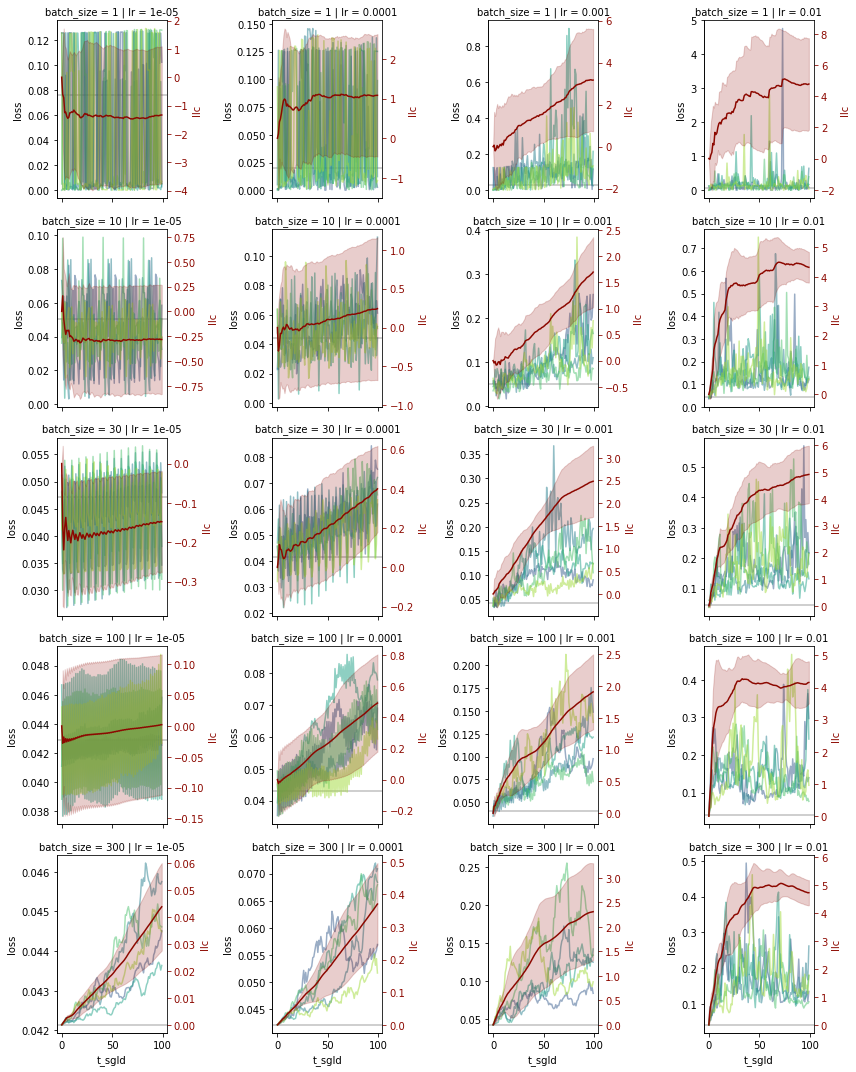

In [120]:
# Plot SGLD hyperparameter grid sweep

import seaborn as sns

def plot_lambdahat_estimation_hyperparams(observations_df):
    def plot_losses(data, **kwargs):
        if kwargs["label"] == "mean":
            plt.axhline(data.loc[data.t_sgld == 0, "loss"].values[0], color="grey", alpha=0.5)
            return
    
        _data = data.loc[data.llc_type != "mean"]
        sns.lineplot(_data, x="t_sgld", y="loss", **kwargs, alpha=0.5)

    def plot_llcs(data, **kwargs):
        if kwargs["label"] != "mean":
            return
        _data = data.loc[data.llc_type == "mean"]
        ax = plt.twinx()
        kwargs.pop("color")
        color = sns.color_palette("dark")[3]
        ax.plot(_data['t_sgld'], _data['llc'], color=color, **kwargs)
        ax.fill_between(_data['t_sgld'], _data['llc'] - _data['llc/std'], _data['llc'] + _data['llc/std'], color=color, alpha=0.2)
        ax.set_ylabel("llc", color=color)
        ax.tick_params(axis='y', colors=color)

    g = sns.FacetGrid(observations_df, col="lr", row="batch_size", hue="llc_type", palette="viridis", sharey=False)
    g.map_dataframe(plot_losses)
    g.map_dataframe(plot_llcs)

    g.fig.set_facecolor('white')
    g.fig.tight_layout()

    plt.show()

plot_lambdahat_estimation_hyperparams(lambdahat_sweep_df)

In [123]:
# Sweep covraiance estimation hyperparameters

def sweep_covariance_estimation_hyperparams(
        model, 
        dataset, 
        steps, 
        checkpoints, 
        device=DEVICE, 
        num_chains=NUM_CHAINS_SGLD, 
        num_draws=NUM_DRAWS_SGLD,
        sgld_kwargs=None,
):
    observations = []
    accessors = {
        "weight": lambda model: model.embedding.weight,
        "bias": lambda model: model.unembedding.bias,
    }
    num_weights = sum([v(model).numel() for v in accessors.values()])
    callbacks = [
        CovarianceAccumulator(num_weights, list(accessors.values()), device=device),
    ]

    hyperparam_combos = list(itertools.product([1, 300], [0., 0.5, 1.]))

    sgld_kwargs = sgld_kwargs or {}
    sgld_kwargs.setdefault("num_samples", len(dataset))
    sgld_kwargs.setdefault("elasticity", 0.)
    sgld_kwargs.setdefault("lr", 0.01)

    for batch_size, noise_level in tqdm(hyperparam_combos, desc="Sweeping hyperparameters"):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for step, checkpoint in zip(steps, checkpoints):
            model.load_state_dict({k: torch.Tensor(v) for k, v in checkpoint.items()})
            optimizer_kwargs = {
                "noise_level": noise_level,
                **sgld_kwargs
            }
            observation = estimate_learning_coeff_with_summary(
                model,
                loader,
                F.mse_loss,
                device=device, # type: ignore
                sampling_method=SGLD,
                optimizer_kwargs=optimizer_kwargs,
                verbose=False,
                num_draws=num_draws,
                num_chains=num_chains,
                callbacks=callbacks
            )

            evals, _, _ = observation.pop("evals"), observation.pop("evecs"), observation.pop("matrix")

            for i, eval in enumerate(evals):
                observations.append({
                    "step": step,
                    "batch_size": batch_size,
                    **optimizer_kwargs,
                    "eval": eval,
                    "eval_idx": i,
                    **observation
                })

            for callback in callbacks:
                callback.reset()

    observations_df = pd.DataFrame(observations)
    return observations_df

model = ToyAutoencoder(NUM_FEATURES, NUM_HIDDEN_UNITS, final_bias=True)
covariance_estimation_sweep_df = sweep_covariance_estimation_hyperparams(model, dataset_double, steps, weights)
covariance_estimation_sweep_df

Sweeping hyperparameters: 0it [00:00, ?it/s]/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
Sweeping hyperparameters: 6it [08:46, 87.76s/it]


,step,batch_size,noise_level,num_samples,elasticity,lr,eval,eval_idx,llc/mean,llc/std,llc-chain/0,llc-chain/1,llc-chain/2,llc-chain/3,llc-chain/4,loss/trace
0,1,1,0.0,200,0.0,0.01,0.375033,0,-2615.538086,5.415445,-2618.391602,-2618.787354,-2617.296875,-2604.753906,-2618.460938,"[[77.87206, 71.48864, 60.542076, 56.66467, 53...."
1,1,1,0.0,200,0.0,0.01,0.653787,1,-2615.538086,5.415445,-2618.391602,-2618.787354,-2617.296875,-2604.753906,-2618.460938,"[[77.87206, 71.48864, 60.542076, 56.66467, 53...."
2,1,1,0.0,200,0.0,0.01,35.736336,2,-2615.538086,5.415445,-2618.391602,-2618.787354,-2617.296875,-2604.753906,-2618.460938,"[[77.87206, 71.48864, 60.542076, 56.66467, 53...."
3,2,1,0.0,200,0.0,0.01,0.330756,0,-2602.649170,5.072272,-2606.047363,-2604.936035,-2605.287109,-2604.415039,-2592.560303,"[[77.483, 68.4244, 63.85772, 56.84188, 51.0677..."
4,2,1,0.0,200,0.0,0.01,0.644633,1,-2602.649170,5.072272,-2606.047363,-2604.936035,-2605.287109,-2604.415039,-2592.560303,"[[77.483, 68.4244, 63.85772, 56.84188, 51.0677..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,16340,300,1.0,200,0.0,0.01,2.535201,1,4.925867,1.144269,6.725489,4.202191,3.921883,5.831648,3.948121,"[[0.042196076, 0.06756074, 0.066153996, 0.0854..."
824,16340,300,1.0,200,0.0,0.01,2.671968,2,4.925867,1.144269,6.725489,4.202191,3.921883,5.831648,3.948121,"[[0.042196076, 0.06756074, 0.066153996, 0.0854..."
825,20000,300,1.0,200,0.0,0.01,1.247780,0,4.501099,0.340669,5.102676,4.441565,4.443587,4.041872,4.475793,"[[0.04217378, 0.062944405, 0.09069713, 0.10853..."
826,20000,300,1.0,200,0.0,0.01,1.933344,1,4.501099,0.340669,5.102676,4.441565,4.443587,4.041872,4.475793,"[[0.04217378, 0.062944405, 0.09069713, 0.10853..."


/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-124-25268b11a0b3>:10: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


<Figure size 1080x432 with 0 Axes>

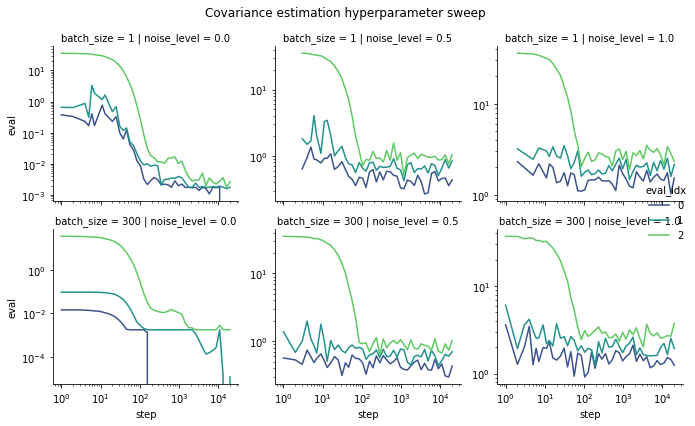

In [124]:
def plot_covariance_estimation_hyperparam_sweep(observations_df):
    fig = plt.figure(figsize=(15, 6))

    g = sns.FacetGrid(observations_df, col="noise_level", row="batch_size", hue="eval_idx", palette="viridis", sharey=False)
    g.map_dataframe(sns.lineplot, x="step", y="eval")
    g.add_legend()
    g.set(xscale="log", yscale="log")

    plt.suptitle("Covariance estimation hyperparameter sweep")
    g.fig.tight_layout()
    plt.show()


plot_covariance_estimation_hyperparam_sweep(covariance_estimation_sweep_df)

In [136]:

from typing import List
from devinterp.slt.callback import ChainCallback
from devinterp.slt.cov import WeightAccessor
from scipy.sparse.linalg import eigsh


class CovarianceAccumulator(ChainCallback):
    """
    A callback to iteratively compute and store the covariance matrix of model weights.
    For use with `estimate`. 

    Attributes:
        num_weights (int): Total number of weights.
        first_moment (torch.Tensor): First moment of weights.
        second_moment (torch.Tensor): Second moment of weights.
        num_draws (int): Number of draws made to accumulate moments.
        accessors (List[WeightAccessor]): Functions to access model weights.
        num_evals (int): Number of eigenvalues to compute.
    """
    def __init__(self, num_draws_per_chain: int, num_chains: int, num_weights: int, accessors: List[WeightAccessor], device = "cpu", num_evals=3):
        """
        Initialize the accumulator.
        """        
        self.num_weights = num_weights
        self.first_moment = torch.zeros(num_weights, device=device)
        self.second_moment = torch.zeros(num_weights, num_weights, device=device)
        self.num_draws = num_draws_per_chain * num_chains
        self.accessors = accessors
        self.num_evals = num_evals
        self.is_finished = False

    def accumulate(self, model: nn.Module):
        """Accumulate moments from model weights."""
        assert not self.is_finished, "Cannot accumulate after finalizing."

        weights = torch.cat([accessor(model).view((-1,)) for accessor in self.accessors])
        self.first_moment += weights / self.num_draws
        self.second_moment += torch.outer(weights, weights) / self.num_draws
        # print(self.first_moment.mean(), self.second_moment.mean())

    def finalize(self):
        """Finalize the moments by dividing by the number of draws."""
        self.is_finished = True

    def reset(self):
        """Reset the accumulator."""
        self.first_moment.zero_()
        self.second_moment.zero_()
        self.is_finished = False

    def to_matrix(self):
        """Convert the moments to a covariance matrix."""
        return self.second_moment - torch.outer(self.first_moment, self.first_moment)

    def to_eigen(self, include_matrix=False):
        """Convert the covariance matrix to pairs of eigenvalues and vectors."""
        cov = self.to_matrix().detach().cpu().numpy()
        evals, evecs = eigsh(cov, k=self.num_evals, which='LM')

        results = {
            "evals": evals,
            "evecs": evecs
        }

        if include_matrix:
            results["matrix"] = cov

        return results

    def sample(self):
        return self.to_eigen(include_matrix=True)
        
    def __call__(self, model):
        self.accumulate(model)

Sweeping hyperparameters:   0%|          | 0/6 [00:00<?, ?it/s]

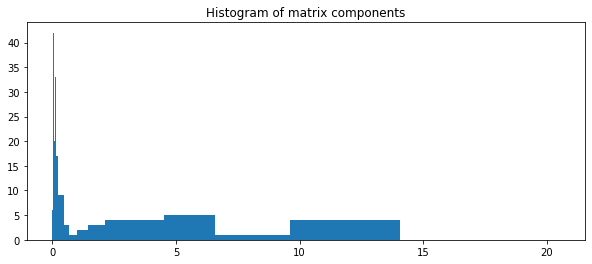

[[ 1.76810086e-01  3.41893137e-02 -7.96602741e-02  3.50405499e-02
  -1.04656458e-01  8.53637457e-02  1.38561130e-01  1.63392685e-02
  -9.98180434e-02 -1.90215111e-02  4.57569994e-02 -1.86500736e-02
   5.98121956e-02 -5.07277437e-02 -7.90795535e-02 -1.22776562e-02
  -2.72570550e-01 -3.66072357e-02 -9.10482168e-01 -1.94883451e-01
  -5.34379423e-01  7.62939453e-06 -1.31130219e-05 -4.72259223e-01]
 [ 3.41893137e-02  1.22686744e-01 -1.03489786e-01  9.25862789e-03
  -1.93782002e-02  1.48251310e-01  1.30195633e-01 -2.52519548e-03
  -2.93201357e-02 -7.81605840e-02  7.48916566e-02 -1.62924826e-02
   1.25032179e-02 -9.19106305e-02 -8.50490183e-02  5.93371689e-04
  -8.44841599e-02 -2.00034976e-02 -2.87404060e-01 -8.63320529e-02
  -1.67473793e-01 -2.95639038e-05  1.95503235e-05 -1.59380674e-01]
 [-7.96602741e-02 -1.03489786e-01  2.87500829e-01 -1.06924072e-01
   1.01754859e-01 -2.51998395e-01 -2.65360296e-01  5.40082529e-02
   5.73537126e-02  7.39653409e-02 -1.89851135e-01  6.37578741e-02
  -5.265

/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


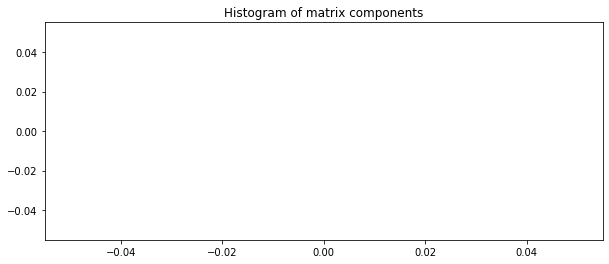

Sweeping hyperparameters:   0%|          | 0/6 [00:04<?, ?it/s]

[[           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
      

RuntimeError: torch.linalg.eig: input tensor should not contain infs or NaNs.

In [138]:
# Let's see whether the eigenvalue estimates are actually accurate

def plot_matrix_components_histogram(matrix, bins=50):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    flattened_matrix = np.abs(matrix.flatten())
    bins_logspace = np.logspace(np.log10(flattened_matrix.min()), np.log10(flattened_matrix.max()), bins)
    ax.hist(matrix.flatten(), bins=bins_logspace)
    ax.set_title("Histogram of matrix components")
    plt.show()

def sweep_covariance_estimation_hyperparams_explicit(
        model, 
        dataset, 
        steps, 
        checkpoints, 
        device=DEVICE, 
        num_chains=NUM_CHAINS_SGLD, 
        num_draws=NUM_DRAWS_SGLD,
        sgld_kwargs=None,
):
    observations = []
    accessors = {
        "weight": lambda model: model.embedding.weight,
        "bias": lambda model: model.unembedding.bias,
    }
    num_weights = sum([v(model).numel() for v in accessors.values()])
    callbacks = [
        CovarianceAccumulator(num_draws, num_chains, num_weights, list(accessors.values()), device=device),
    ]

    hyperparam_combos = list(itertools.product([1, 300], [0., 0.5, 1.]))

    sgld_kwargs = sgld_kwargs or {}
    sgld_kwargs.setdefault("num_samples", len(dataset))
    sgld_kwargs.setdefault("elasticity", 0.)
    sgld_kwargs.setdefault("lr", 0.01)

    for batch_size, noise_level in tqdm(hyperparam_combos, desc="Sweeping hyperparameters"):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for step, checkpoint in zip(steps, checkpoints):
            model.load_state_dict({k: torch.Tensor(v) for k, v in checkpoint.items()})
            optimizer_kwargs = {
                "noise_level": noise_level,
                **sgld_kwargs
            }
            observation = estimate_learning_coeff_with_summary(
                model,
                loader,
                F.mse_loss,
                device=device, # type: ignore
                sampling_method=SGLD,
                optimizer_kwargs=optimizer_kwargs,
                verbose=False,
                num_draws=num_draws,
                num_chains=num_chains,
                callbacks=callbacks
            )

            _, _, cov_matrix = observation.pop("evals"), observation.pop("evecs"), observation.pop("matrix")

            plot_matrix_components_histogram(cov_matrix)
            
            cov_matrix = torch.tensor(cov_matrix)
            eigenresult = torch.linalg.eig(cov_matrix)
            evals = sorted(eigenresult.eigenvalues.real, reverse=True)[:5]

            for i, eval in enumerate(evals):
                observations.append({
                    "step": step,
                    "batch_size": batch_size,
                    **optimizer_kwargs,
                    "eval": eval,
                    "eval_idx": i,
                    **observation
                })

            for callback in callbacks:
                callback.reset()

    observations_df = pd.DataFrame(observations)
    return observations_df

model = ToyAutoencoder(NUM_FEATURES, NUM_HIDDEN_UNITS, final_bias=True)
covariance_estimation_sweep_explicit_df = sweep_covariance_estimation_hyperparams_explicit(model, dataset_double, steps, weights)
# covariance_estimation_sweep_explicit_df
plot_covariance_estimation_hyperparam_sweep(covariance_estimation_sweep_explicit_df)